<a href="https://colab.research.google.com/github/torquerxf/Delivery-Duration-Prediction/blob/main/doordash_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Steps Breakdown

- Data Preprocessing
- Feature Engineering
- Encoding & Scaling
- Model Selection
- Evaluation
- Model Interpretation

### Data Preprocessing

In [ ]:
!git clone https://github.com/torquerxf/delivery-duration-prediction.git
%cd delivery-duration-prediction

!unzip data/datasets.zip -d extracted

import pandas as pd
df = pd.read_csv("extracted/datasets/historical_data.csv")

fatal: destination path 'delivery-duration-prediction' already exists and is not an empty directory.
/content/delivery-duration-prediction
Archive:  datasets.zip
replace extracted/datasets/historical_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: extracted/datasets/historical_data.csv  


In [2]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [4]:
df.isnull().sum()

,0
market_id,987
created_at,0
actual_delivery_time,7
store_id,0
store_primary_category,4760
order_protocol,995
total_items,0
subtotal,0
num_distinct_items,0
min_item_price,0


In [5]:
qual_vars = ['market_id', 'store_id', 'store_primary_category', 'order_protocol']
df[qual_vars].nunique()

,0
market_id,6
store_id,6743
store_primary_category,74
order_protocol,7


Quick Notes:
- market_id, store_id, store_primary_category, order_protocol seem to categorical variables
- created_at and actual_delivery_time have object dtype ---> need to fix it to datatime


In [6]:
data = df.copy() # a copy of the original
# convert the dates to datetime format
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])
# calculate delivery_duration
data['delivery_duration'] = (data['actual_delivery_time'] - data['created_at']).dt.total_seconds()

In [7]:
# drop the not-so relevant features
data.drop(columns=['created_at', 'actual_delivery_time'], inplace=True)

Quick Notes:
- store_primary_category null values can be imputed with a map which maps store_id to its most frequent category

In [8]:
store_id_list = data['store_id'].unique()

store_primary_category_map = {store_id : data[data['store_id'] == store_id]['store_primary_category'].mode() for store_id in store_id_list}



In [9]:
import numpy as np
def fill(store_id):
  try:
    return store_primary_category_map[store_id][0]
  except:
    return np.nan

data['nan_store_primary_category'] = data['store_id'].apply(fill)

In [10]:
data['nan_store_primary_category'].isnull().sum()

np.int64(867)

### Feature Engineering

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   store_id                                      197428 non-null  int64  
 2   store_primary_category                        192668 non-null  object 
 3   order_protocol                                196433 non-null  float64
 4   total_items                                   197428 non-null  int64  
 5   subtotal                                      197428 non-null  int64  
 6   num_distinct_items                            197428 non-null  int64  
 7   min_item_price                                197428 non-null  int64  
 8   max_item_price                                197428 non-null  int64  
 9   total_onshift_dashers                         18

Quick Notes:
- dasher_availability_ration = total_busy_dashers / total_onshift_dashers
- the above ratio can contain infinte values! --> fix with adding 1 to denominator
- can combine estimated_order_place_duration and estimated_store_to_consumer_driving_duration as a non_prep_duration  --> (total_processing_time = prep_duration + non_prep_duration)
- price_range = max_item_price - min_item_price
- avg_item_price = subtotal / total_items

In [12]:
# this block should've been in the previous section but..
numeric_cols = ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration']

for col in numeric_cols:
  data = data[data[col] > 0]

In [13]:
data.shape

(173763, 16)

In [14]:
data['dasher_availability_ratio'] = data['total_busy_dashers'] / (data['total_onshift_dashers']+1)
data['non_prep_duration'] = data['estimated_order_place_duration'] + data['estimated_store_to_consumer_driving_duration']
data['price_range'] = data['max_item_price'] - data['min_item_price']
data['avg_item_price'] = data['subtotal'] / data['total_items']
data['distinct_items_ratio'] = data['num_distinct_items'] / data['total_items']

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 173763 entries, 0 to 197427
Data columns (total 21 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     172880 non-null  float64
 1   store_id                                      173763 non-null  int64  
 2   store_primary_category                        169685 non-null  object 
 3   order_protocol                                172873 non-null  float64
 4   total_items                                   173763 non-null  int64  
 5   subtotal                                      173763 non-null  int64  
 6   num_distinct_items                            173763 non-null  int64  
 7   min_item_price                                173763 non-null  int64  
 8   max_item_price                                173763 non-null  int64  
 9   total_onshift_dashers                         173763 

In [16]:
numeric_features = data.drop(columns=[
                              'market_id',
                              'store_id',
                              'store_primary_category',
                              'order_protocol',
                              'nan_store_primary_category'
                              ])

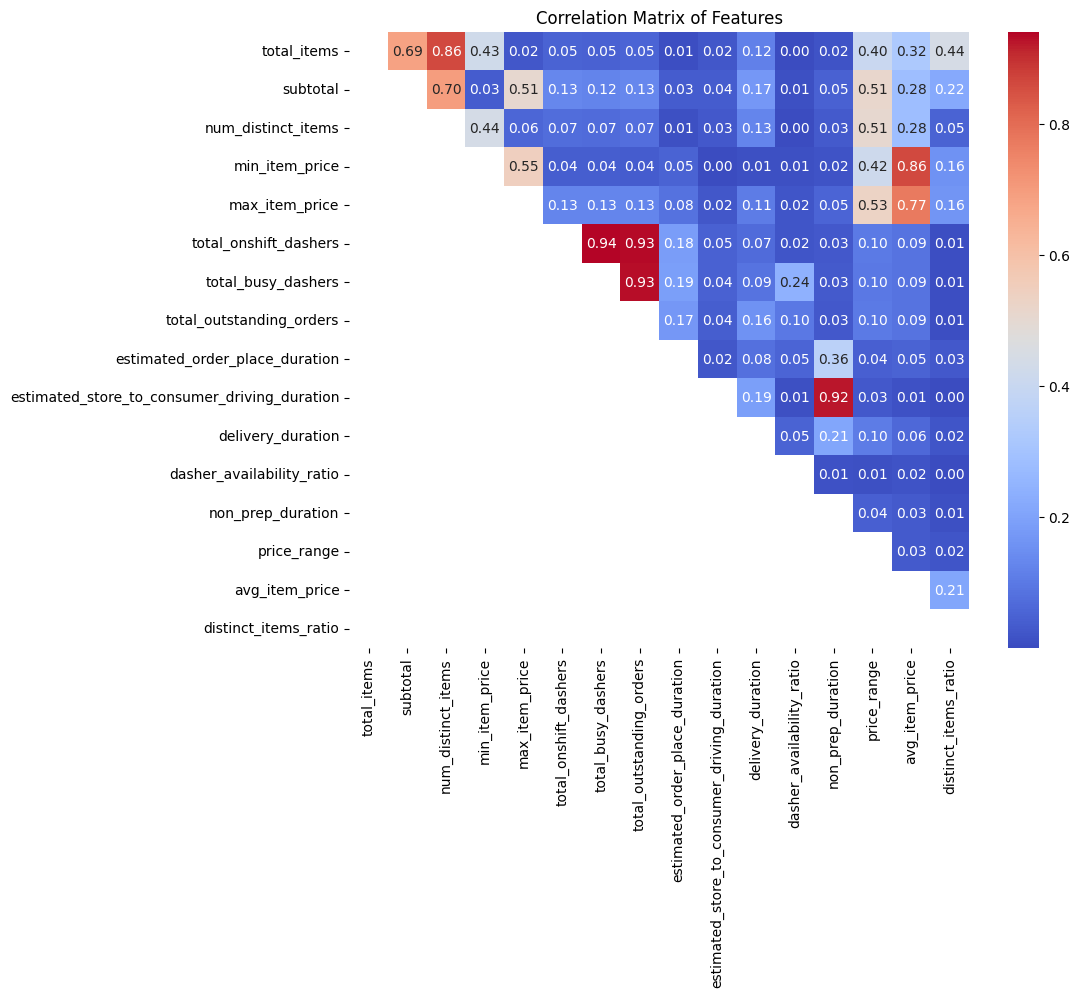

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# collinearity check for redundant features
corr_matrix = numeric_features.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

plt.figure(figsize=(10, 8))
sns.heatmap(upper_tri, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [18]:
# drop correlated features
collinear_to_drop = [
    'total_onshift_dashers',
    'total_busy_dashers',
    'subtotal',
    'num_distinct_items',
    'min_item_price',
    'max_item_price',
    'non_prep_duration'
]

data.drop(columns=collinear_to_drop, inplace=True)

In [19]:
numeric_features = data.drop(columns=[
                              'market_id',
                              'store_id',
                              'store_primary_category',
                              'order_protocol',
                              'nan_store_primary_category'
                              ])

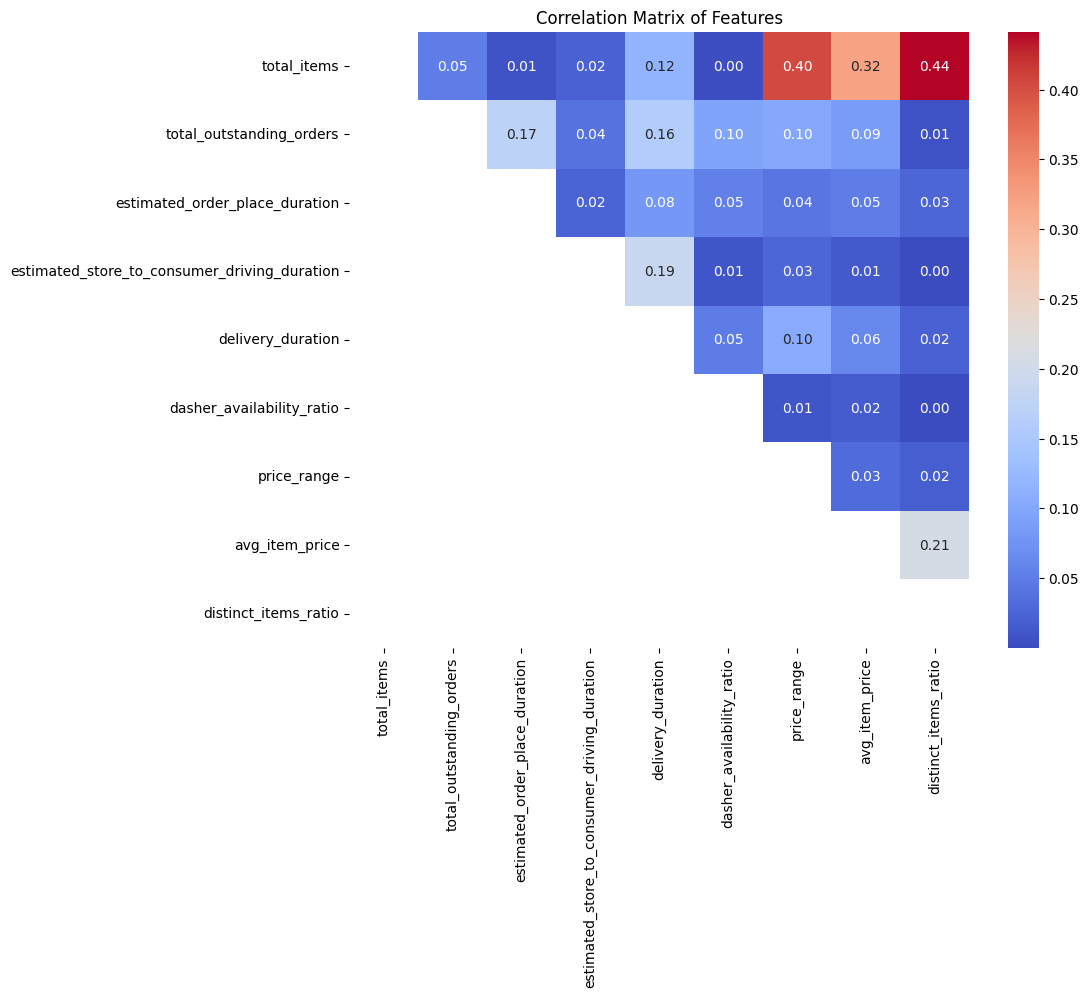

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# collinearity check for redundant features
corr_matrix = numeric_features.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

plt.figure(figsize=(10, 8))
sns.heatmap(upper_tri, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 173763 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     172880 non-null  float64
 1   store_id                                      173763 non-null  int64  
 2   store_primary_category                        169685 non-null  object 
 3   order_protocol                                172873 non-null  float64
 4   total_items                                   173763 non-null  int64  
 5   total_outstanding_orders                      173763 non-null  float64
 6   estimated_order_place_duration                173763 non-null  int64  
 7   estimated_store_to_consumer_driving_duration  173763 non-null  float64
 8   delivery_duration                             173756 non-null  float64
 9   nan_store_primary_category                    173058 

In [22]:
data.describe()

,market_id,store_id,order_protocol,total_items,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration,dasher_availability_ratio,price_range,avg_item_price,distinct_items_ratio
count,172880.000000,173763.000000,172873.000000,173763.000000,173763.000000,173763.000000,173763.000000,173756.000000,173763.000000,173763.000000,173763.000000,173763.000000
mean,2.771836,3547.605572,2.895067,3.126333,59.669170,308.599736,546.932891,2856.593200,0.907046,472.377704,985.422166,0.905232
std,1.329398,2059.498710,1.514111,2.235395,52.568963,89.965866,218.363475,1399.761507,0.310984,513.895598,513.702476,0.177260
min,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,1.000000,101.000000,0.055556,-197.000000,17.375000,0.029412
25%,2.000000,1686.000000,1.000000,2.000000,19.000000,251.000000,385.000000,2103.000000,0.788235,0.000000,655.000000,0.857143
50%,2.000000,3617.000000,3.000000,3.000000,43.000000,251.000000,546.000000,2657.000000,0.921053,370.000000,899.000000,1.000000
75%,4.000000,5336.000000,4.000000,4.000000,87.000000,446.000000,704.000000,3373.250000,0.983051,750.000000,1197.500000,1.000000
max,6.000000,6987.000000,7.000000,48.000000,285.000000,2715.000000,2088.000000,332482.000000,15.500000,8400.000000,14700.000000,1.000000


<Axes: xlabel='total_items'>

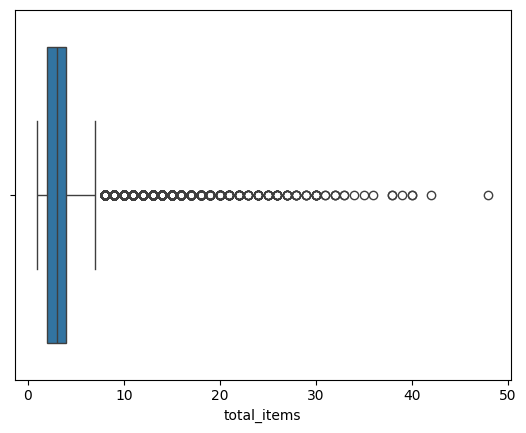

In [23]:
import seaborn as sns

sns.boxplot(data['total_items'], orient='h')

<Axes: xlabel='total_outstanding_orders'>

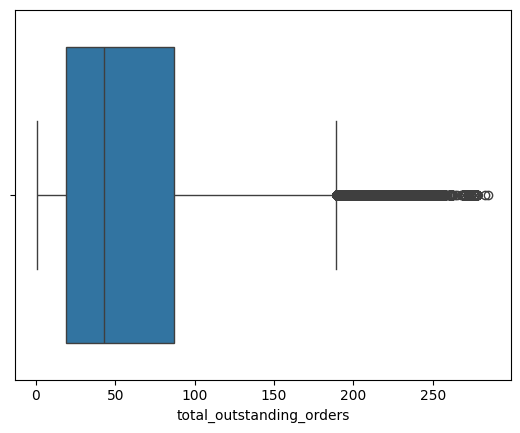

In [24]:
sns.boxplot(data['total_outstanding_orders'], orient='h')

<Axes: xlabel='estimated_order_place_duration'>

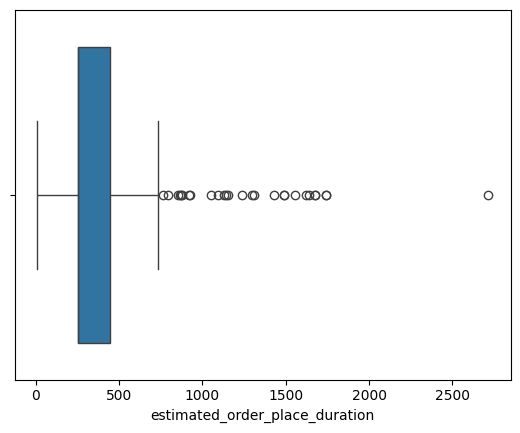

In [25]:
sns.boxplot(data['estimated_order_place_duration'], orient='h')

In [26]:
data['delivery_duration'].sort_values(ascending=False).head()

,delivery_duration
27189,332482.0
83055,57032.0
190860,54447.0
86952,48178.0
76743,45685.0


Quick Notes:
- delivery_duration has one extreme value and will get removed

In [27]:
data.shape

(173763, 14)

In [28]:
data = data[data['delivery_duration'] != 332482.0]

<Axes: xlabel='dasher_availability_ratio'>

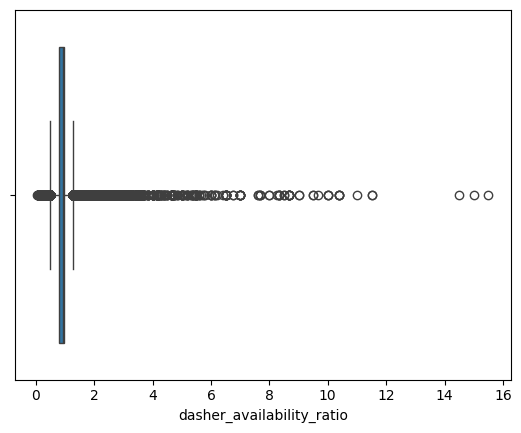

In [29]:
sns.boxplot(data['dasher_availability_ratio'], orient='h')

In [30]:
# transform all the numeric_cols except the target (delivery_duration)
to_logtransform = data.drop(columns=[
                              'market_id',
                              'store_id',
                              'store_primary_category',
                              'order_protocol',
                              'nan_store_primary_category',
                              'delivery_duration'
                              ])

In [32]:
data.columns

Index(['market_id', 'store_id', 'store_primary_category', 'order_protocol',
       'total_items', 'total_outstanding_orders',
       'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'delivery_duration',
       'nan_store_primary_category', 'dasher_availability_ratio',
       'price_range', 'avg_item_price', 'distinct_items_ratio'],
      dtype='object')

In [34]:
# log transform to all numeric cols
for col in to_logtransform:
  data[col] = np.log1p(data[col])

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [35]:
data.describe()

,market_id,store_id,order_protocol,total_items,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration,dasher_availability_ratio,price_range,avg_item_price,distinct_items_ratio
count,172879.000000,173762.000000,172872.000000,173762.000000,173762.000000,173762.000000,173762.000000,173755.000000,173762.000000,1.730710e+05,173762.000000,173762.000000
mean,2.771846,3547.601023,2.895067,0.591331,3.664211,5.698372,6.206947,2854.696130,0.635884,-inf,6.776400,0.639675
std,1.329395,2059.503763,1.514115,0.107752,1.037255,0.262643,0.484679,1154.995181,0.133298,NaN,0.492728,0.102633
min,1.000000,1.000000,1.000000,0.423036,0.693147,2.397895,0.693147,101.000000,0.054067,-inf,2.910991,0.028988
25%,2.000000,1686.000000,1.000000,0.554618,2.995732,5.529429,5.955837,2103.000000,0.581229,0.000000e+00,6.486161,0.619039
50%,2.000000,3617.000000,3.000000,0.625800,3.784190,5.529429,6.304449,2657.000000,0.652873,5.929589e+00,6.802395,0.693147
75%,4.000000,5336.000000,4.000000,0.672503,4.477337,6.102559,6.558198,3373.000000,0.684636,6.621406e+00,7.088826,0.693147
max,6.000000,6987.000000,7.000000,0.950717,5.655992,7.906915,7.644441,57032.000000,2.803360,9.036106e+00,9.595671,0.693147


In [36]:
# convert -inf and inf values in price_range to np.nan
data = data.replace([-np.inf, np.inf], np.nan)

### Encoding & Scaling

Quick Notes:
- will use OneHotEncode for market_id, nan_store_primary_category and order_protocol, reason being they're categorical
- can apply StandardScaler/MinMaxScaler on numerical features

In [37]:
market_id_encoded = pd.get_dummies(data['market_id'], prefix='market_id')

In [38]:
store_primary_category_encoded = pd.get_dummies(data['nan_store_primary_category'], prefix='category')
store_primary_category_encoded.head()

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [39]:
order_protocol_encoded = pd.get_dummies(data['order_protocol'], prefix='protocol')
order_protocol_encoded.head()

,protocol_1.0,protocol_2.0,protocol_3.0,protocol_4.0,protocol_5.0,protocol_6.0,protocol_7.0
0,True,False,False,False,False,False,False
1,False,True,False,False,False,False,False
3,True,False,False,False,False,False,False
4,True,False,False,False,False,False,False
5,True,False,False,False,False,False,False


In [40]:
data_encoded = pd.concat([data.drop(columns=['market_id', 'store_primary_category', 'nan_store_primary_category', 'order_protocol'], axis=1), market_id_encoded, store_primary_category_encoded, order_protocol_encoded],  axis=1)

In [41]:
data_encoded.drop(columns='store_id', inplace=True)

In [42]:
data_encoded.shape

(173762, 95)

In [43]:
data_encoded.isnull().sum().unique()

array([  0,   7, 706])

In [44]:
data.isnull().sum() # to check how many null values originally

,0
market_id,883
store_id,0
store_primary_category,4078
order_protocol,890
total_items,0
total_outstanding_orders,0
estimated_order_place_duration,0
estimated_store_to_consumer_driving_duration,0
delivery_duration,7
nan_store_primary_category,705


In [45]:
data_encoded.dropna(inplace=True)

In [46]:
data_encoded.shape

(173049, 95)

In [47]:
data_encoded.isnull().sum().unique()

array([0])

In [48]:
data_encoded['dasher_availability_ratio'].describe()

,dasher_availability_ratio
count,173049.000000
mean,0.635824
std,0.133235
min,0.054067
25%,0.581229
50%,0.652873
75%,0.684636
max,2.803360


In [49]:
data_encoded.isnull().sum().unique()

array([0])

<Axes: >

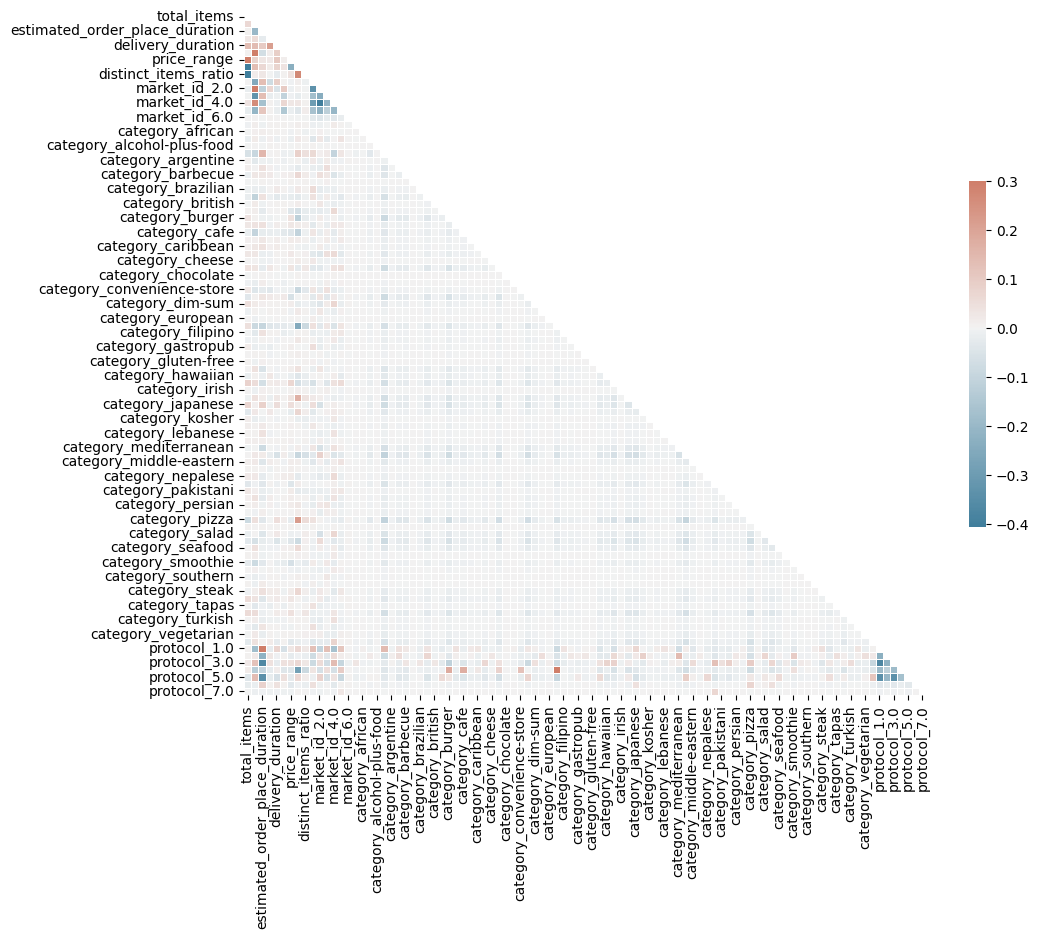

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# collinearity check for redundant features
corr_matrix = data_encoded.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={'shrink': .5})

In [51]:
data_encoded.shape

(173049, 95)

In [52]:
data_encoded.describe()

,total_items,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration,dasher_availability_ratio,price_range,avg_item_price,distinct_items_ratio
count,173049.000000,173049.000000,173049.000000,173049.000000,173049.000000,173049.000000,173049.000000,173049.000000,173049.000000
mean,0.591804,3.663936,5.698339,6.206930,2855.282729,0.635824,4.492222,6.774842,0.639697
std,0.107580,1.037743,0.262634,0.484590,1155.332814,0.133235,2.836342,0.492043,0.102527
min,0.423036,0.693147,2.397895,0.693147,101.000000,0.054067,0.000000,2.910991,0.028988
25%,0.554618,2.995732,5.529429,5.955837,2104.000000,0.581229,0.000000,6.484635,0.619039
50%,0.625800,3.784190,5.529429,6.304449,2658.000000,0.652873,5.929589,6.802395,0.693147
75%,0.672503,4.477337,6.102559,6.558198,3374.000000,0.684636,6.621406,7.086738,0.693147
max,0.950717,5.655992,7.906915,7.644441,57032.000000,2.803360,9.036106,9.595671,0.693147


### Model Selection

In [53]:
# split the features and target
X = data_encoded.drop(columns='delivery_duration')
y = data_encoded['delivery_duration']

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# define a function to check various models
def run_model(model, X_train, X_test, y_train, y_test):
  print('---------------------------------------------')
  print('Model:', type(model).__name__)
  # fit the training dataset into the model
  model.fit(X_train, y_train)
  # get predictions on X_test
  y_pred = model.predict(X_test)
  # convert the log version of y_pred back
  # y_pred = np.expm1(y_pred)

  # Evaluation
  print('MAE:', mean_absolute_error(y_test, y_pred))
  print('RMSE:', root_mean_squared_error(y_test, y_pred))
  print('R2_Score', r2_score(y_test, y_pred))
  print('---------------------------------------------')

In [63]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [64]:
print('Training on non-scaled features:')
run_model(LinearRegression(), X_train, X_test, y_train, y_test)
run_model(
    XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=8, random_state=42),
    X_train, X_test, y_train, y_test)
run_model(
    LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=8, random_state=42),
    X_train, X_test, y_train, y_test)

Training on non-scaled features:
---------------------------------------------
Model: LinearRegression
MAE: 733.666058473202
RMSE: 1020.6116425633442
R2_Score 0.14748437265871495
---------------------------------------------
---------------------------------------------
Model: XGBRegressor
MAE: 684.0568371860667
RMSE: 963.7796453623376
R2_Score 0.23978433893818563
---------------------------------------------
---------------------------------------------
Model: LGBMRegressor
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1590
[LightGBM] [Info] Number of data points in the train set: 138439, number of used features: 82
[LightGBM] [Info] Start training from score 2858.261270
MAE: 684.9134903664745
RMSE: 963.6312811890749
R2_Score 0.2400183760176151
-----------------------------------

- The error value is high
- trying to scale the features

In [65]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# list of scalers to be use
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

print('Training using Scaled Features:')

# iterating through the scalers array
for scaler in scalers:
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  print('Scaler:', type(scaler).__name__)
  run_model(LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test)
  run_model(
      XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=8, random_state=42),
      X_train_scaled, X_test_scaled, y_train, y_test)
  run_model(
      LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=8, random_state=42),
      X_train_scaled, X_test_scaled, y_train, y_test)

Training using Scaled Features:
Scaler: StandardScaler
---------------------------------------------
Model: LinearRegression
MAE: 733.6660584732025
RMSE: 1020.6116425633442
R2_Score 0.14748437265871495
---------------------------------------------
---------------------------------------------
Model: XGBRegressor
MAE: 684.0568371860667
RMSE: 963.7796453623376
R2_Score 0.23978433893818563
---------------------------------------------
---------------------------------------------
Model: LGBMRegressor
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1602
[LightGBM] [Info] Number of data points in the train set: 138439, number of used features: 82
[LightGBM] [Info] Start training from score 2858.261270
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MAE: 684.9957524226147
RMSE: 963.9096753445566
R2_Score 0.23957919350337453
---------------------------------------------
Scaler: MinMaxScaler
---------------------------------------------
Model: LinearRegression
MAE: 733.6660584732024
RMSE: 1020.6116425633442
R2_Score 0.14748437265871495
---------------------------------------------
---------------------------------------------
Model: XGBRegressor
MAE: 684.0568371860667
RMSE: 963.7796453623376
R2_Score 0.23978433893818563
---------------------------------------------
---------------------------------------------
Model: LGBMRegressor
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1588
[LightGBM] [Info] Number of data points in the train set: 138439, number of used features: 82
[LightGBM] [Info] Start training from score 2858.261270

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MAE: 684.9997600092303
RMSE: 963.6362513442327
R2_Score 0.2400105364291688
---------------------------------------------
Scaler: RobustScaler
---------------------------------------------
Model: LinearRegression
MAE: 733.6660584732024
RMSE: 1020.6116425633442
R2_Score 0.14748437265871495
---------------------------------------------
---------------------------------------------
Model: XGBRegressor
MAE: 684.0568371860667
RMSE: 963.7796453623376
R2_Score 0.23978433893818563
---------------------------------------------
---------------------------------------------
Model: LGBMRegressor
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1582
[LightGBM] [Info] Number of data points in the train set: 138439, number of used features: 82
[LightGBM] [Info] Start training from score 2858.261270


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MAE: 684.7715633916569
RMSE: 963.4126717166013
R2_Score 0.24036315589343904
---------------------------------------------


### Model Interpretation